In [248]:
import json
import pandas as pd
import numpy as np
import os
import seaborn as sns
import re
from collections import *
from tqdm import tqdm

In [300]:
directory_path = 'data/raw'
filenames = sorted(os.listdir(directory_path))

In [301]:
filenames

['mpd.slice.0-999.json',
 'mpd.slice.1000-1999.json',
 'mpd.slice.10000-10999.json',
 'mpd.slice.100000-100999.json',
 'mpd.slice.101000-101999.json',
 'mpd.slice.102000-102999.json',
 'mpd.slice.103000-103999.json',
 'mpd.slice.104000-104999.json',
 'mpd.slice.105000-105999.json',
 'mpd.slice.106000-106999.json',
 'mpd.slice.107000-107999.json',
 'mpd.slice.108000-108999.json',
 'mpd.slice.109000-109999.json',
 'mpd.slice.11000-11999.json',
 'mpd.slice.110000-110999.json',
 'mpd.slice.111000-111999.json',
 'mpd.slice.112000-112999.json',
 'mpd.slice.113000-113999.json',
 'mpd.slice.114000-114999.json',
 'mpd.slice.115000-115999.json',
 'mpd.slice.116000-116999.json',
 'mpd.slice.117000-117999.json',
 'mpd.slice.118000-118999.json',
 'mpd.slice.119000-119999.json',
 'mpd.slice.12000-12999.json',
 'mpd.slice.120000-120999.json',
 'mpd.slice.121000-121999.json',
 'mpd.slice.122000-122999.json',
 'mpd.slice.123000-123999.json',
 'mpd.slice.124000-124999.json',
 'mpd.slice.125000-125999.js

In [302]:
# looking at only the first 10,000 playlists
fullpaths = [directory_path + '/' + f for f in filenames][0:10]

In [304]:
f = open('data/raw/mpd.slice.0-999.json')
js = f.read()
f.close()
mpd_slice = json.loads(js)
playlists_data = mpd_slice['playlists']

In [311]:
mpd_slice['playlists'][1]

{'name': 'Awesome Playlist',
 'collaborative': 'false',
 'pid': 1,
 'modified_at': 1506556800,
 'num_tracks': 39,
 'num_albums': 23,
 'num_followers': 1,
 'tracks': [{'pos': 0,
   'artist_name': 'Survivor',
   'track_uri': 'spotify:track:2HHtWyy5CgaQbC7XSoOb0e',
   'artist_uri': 'spotify:artist:26bcq2nyj5GB7uRr558iQg',
   'track_name': 'Eye of the Tiger',
   'album_uri': 'spotify:album:4PT9VulQaQP6XR1xBI2x1W',
   'duration_ms': 243773,
   'album_name': 'Eye Of The Tiger'},
  {'pos': 1,
   'artist_name': 'Daniel Tidwell',
   'track_uri': 'spotify:track:1MYYt7h6amcrauCOoso3Gx',
   'artist_uri': 'spotify:artist:7zdmbPudNX4SQJXnYIuCTC',
   'track_name': 'Libera Me From Hell (Tengen Toppa Gurren Lagann)',
   'album_uri': 'spotify:album:3q8vR3PFV8kG1m1Iv8DpKq',
   'duration_ms': 70294,
   'album_name': 'Versus Hollywood'},
  {'pos': 2,
   'artist_name': 'Daniel Tidwell',
   'track_uri': 'spotify:track:3x2mJ2bjCIU70NrH49CtYR',
   'artist_uri': 'spotify:artist:7zdmbPudNX4SQJXnYIuCTC',
   'trac

In [316]:
playlists_data['tracks']

TypeError: list indices must be integers or slices, not str

<AxesSubplot:ylabel='Count'>

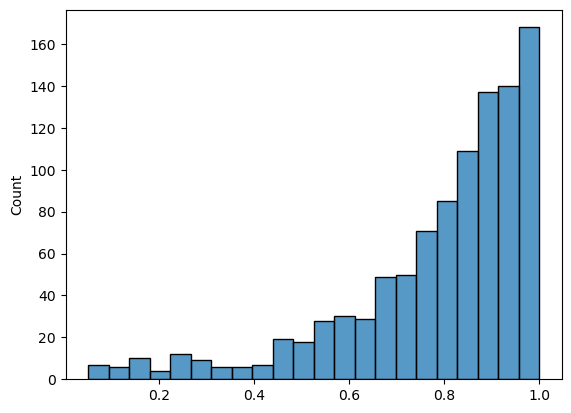

In [317]:
ratios = []
for playlist in playlists_data:
    r = playlist['num_albums']/playlist['num_tracks']
    ratios.append(r)

sns.histplot(ratios)

In [ ]:
def normalize_name(name):
    name = name.lower()
    name = re.sub(r"[.,\/#!$%\^\*;:{}=\_`~()@]", " ", name)
    name = re.sub(r"\s+", " ", name).strip()
    return name

In [318]:
min_tracks_per_playlist = 10
max_tracks_per_playlist = 100
min_albums_per_playlist = 10
min_artists_per_playlist = 10

In [319]:
len(fullpaths)

10

In [299]:
song_relationships = {}

for idx, path in enumerate(fullpaths):
    if idx % 5 == 0 and idx > 0:
        print(f"Processed {idx-5}-{idx}")  # Print the range every 5 chunks
    f = open(path)
    js = f.read()
    f.close()
    mpd_slice = json.loads(js)
    playlists_data = mpd_slice['playlists']

    for idx, playlist in enumerate(playlists_data):
        if idx % 1000 == 0 and idx > 0:
            print(f"Processed {idx - 1000}-{idx}")
        r = playlist['num_albums'] / playlist['num_tracks']
        if r < 0.65:
            continue
        songs = set(track['track_uri'] for track in playlist['tracks'])
        t_per_p = len(songs)
        albums = set(track['album_uri'] for track in playlist['tracks'])
        alb_per_p = len(albums)
        artists = set(track['artist_uri'] for track in playlist['tracks'])
        art_per_p = len(artists)

        if (min_tracks_per_playlist >= t_per_p) or \
             (t_per_p >= max_tracks_per_playlist) or \
                (min_albums_per_playlist >= alb_per_p) or \
                    (min_artists_per_playlist >= art_per_p):
            continue

        for song in songs:
            if song not in song_relationships:
                song_relationships[song] = {}
                
            for s in songs:
                if s != song:  # avoid self-relationship
                    if s in song_relationships[song]:
                        song_relationships[song][s] += 1
                    else:
                        song_relationships[song][s] = 1

            


Processed 0-5


In [293]:
len(song_relationships)

225157

In [294]:
song_relationships_sorted = {}
for song in tqdm(song_relationships):
    song_relationships_sorted[song] = sorted(song_relationships[song].items(),\
                                      key = lambda x: x[1], reverse = True)

100%|██████████| 225157/225157 [00:47<00:00, 4740.59it/s] 


In [320]:
len(song_relationships_sorted)

225157

In [295]:
track_uri = list(song_relationships_sorted.keys())[0]
print(track_uri)
song_relationships_sorted[track_uri]

spotify:track:2nbClS09zsIAqNkshg6jnp


[('spotify:track:34ceTg8ChN5HjrqiIYCn9Q', 44),
 ('spotify:track:4SRqDmPxYX0pUb5B5ut2Ri', 38),
 ('spotify:track:2q4rjDy9WhaN3o9MvDbO21', 35),
 ('spotify:track:4E5P1XyAFtrjpiIxkydly4', 33),
 ('spotify:track:67T6l4q3zVjC5nZZPXByU8', 30),
 ('spotify:track:0XUfyU2QviPAs6bxSpXYG4', 30),
 ('spotify:track:3iL2l5gUqyPS6vDwJFgJTR', 30),
 ('spotify:track:0DdpxWfVvUGgkJv5536tiF', 28),
 ('spotify:track:4gFXY5yvHayGckJndafYQE', 27),
 ('spotify:track:1lzr43nnXAijIGYnCT8M8H', 26),
 ('spotify:track:5xV0Czdqefft6sPDqjmFBu', 26),
 ('spotify:track:2gam98EZKrF9XuOkU13ApN', 23),
 ('spotify:track:1CdkNxTlkUWR4ZnXcKES3b', 23),
 ('spotify:track:0JmGVy7IzUM27My3UuEOOZ', 23),
 ('spotify:track:5i66xrvSh1MjjyDd6zcwgj', 22),
 ('spotify:track:0CAfXk7DXMnon4gLudAp7J', 22),
 ('spotify:track:5hydb8abMsDWNefmuqDYeK', 22),
 ('spotify:track:47x1F4HyX7LafFgxtoa19P', 22),
 ('spotify:track:2kQuhkFX7uSVepCD3h29g5', 22),
 ('spotify:track:5BoIP8Eha5hwmRVURkC2Us', 21),
 ('spotify:track:5dNfHmqgr128gMY2tc5CeJ', 21),
 ('spotify:tr

In [321]:
max_connections = 0
song_with_most_connections = None

for song, connections in song_relationships.items():
    num_connections = len(connections)
    if num_connections > max_connections:
        max_connections = num_connections
        song_with_most_connections = song

print("Song with the most connections:", song_with_most_connections)
print("Number of connections:", max_connections)


Song with the most connections: spotify:track:7BKLCZ1jbUBVqRi2FVlTVw
Number of connections: 5661


In [209]:
sorted(song_relationships[list(song_relationships.keys())[90]].items(), key = lambda x: x[1], reverse = True)

[('spotify:track:6GsAD8PgHxmEuIPTG8GP3M', 5),
 ('spotify:track:4O1CExxinEpKZi3861NlTK', 5),
 ('spotify:track:03fT3OHB9KyMtGMt2zwqCT', 5),
 ('spotify:track:7nDoBWDvf02SyD8kEQuuPO', 4),
 ('spotify:track:7vWGeYZJUzBXKGPro05UXS', 4),
 ('spotify:track:4iLPK8QnOvqm0Azbsk2GDn', 4),
 ('spotify:track:0yD66650JxhqKbW76C2qCo', 4),
 ('spotify:track:4mnuiEDq1ADXUTYWJxLo4B', 4),
 ('spotify:track:1JqVM7aB2AwafhGHRABPAA', 4),
 ('spotify:track:66rVt7PbwyKlu6CK6rxyAi', 4),
 ('spotify:track:6aNwDe5YH5YUPlpHkku52w', 4),
 ('spotify:track:2Fk0WwAqTBesLtKg97nojy', 4),
 ('spotify:track:7mldq42yDuxiUNn08nvzHO', 4),
 ('spotify:track:2QVzUws1l5mzZ4v46tGHrC', 4),
 ('spotify:track:5aj0xPGiEUN3aI2oOYu14S', 4),
 ('spotify:track:0iA1unTbTbDOWUSlbwJ1pS', 4),
 ('spotify:track:5y2pNuAvWcPKiORZ12e44S', 4),
 ('spotify:track:1jNNHFZmRGXZFHlil5uhei', 4),
 ('spotify:track:6GBUsjHfZuweYf5lQEz6mP', 4),
 ('spotify:track:29AR5X5yKPd4DBIAiqUMDy', 3),
 ('spotify:track:7GQjJEwqlp6m5HNWVQd6OR', 3),
 ('spotify:track:69XcvSymPaTke2Qb6